In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

# Stellargraph Vignette - Classification

Implement the code in 
https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html

Some changes to the code are required to get it to work.  It is unclear if stellargraph will be maintained.

Other useful links
  * https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
  * https://stackoverflow.com/questions/43759610/how-to-add-python-3-6-kernel-alongside-3-5-on-jupyter
  * https://gist.github.com/Orbifold/5e267774dcafa58e7e3cafce7e9c73b6
  * https://stellargraph.readthedocs.io/en/v1.2.0/api.html
  * https://medium.com/@angelgaspar/how-to-install-tensorflow-on-a-m1-m2-macbook-with-gpu-acceleration-acfeb988d27e

*This script takes about 2 minutes on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-17 14:05:28.461869: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-17 14:05:28.461895: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-17 14:05:28.461902: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-17 14:05:28.462104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 14:05:28.462123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
from collections import Counter

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
set(node_subjects)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

In [46]:
Counter(train_subjects)

Counter({'Neural_Networks': 81,
         'Genetic_Algorithms': 42,
         'Case_Based': 30,
         'Probabilistic_Methods': 42,
         'Theory': 35,
         'Reinforcement_Learning': 22,
         'Rule_Learning': 18})

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [11]:
batch_size = 50
num_samples = [10, 5]

In [12]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [13]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [14]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [15]:
#Added to vignette (workaround)
np.random.seed(16)
tf.random.set_seed(16)

In [16]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [17]:
x_inp

[<KerasTensor: shape=(None, 1, 1433) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 10, 1433) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 50, 1433) dtype=float32 (created by layer 'input_3')>]

In [18]:
x_out

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>

In [19]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

###### Got this warning:
WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
WARNING:absl:`lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
###### And so changed the above to use a different optimizer.  I am on a mac

In [20]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [21]:
test_gen

In [22]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20


2023-11-17 14:05:29.637057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-17 14:05:30.585362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 - 3s - loss: 1.8807 - acc: 0.2259 - val_loss: 1.7359 - val_acc: 0.3158 - 3s/epoch - 417ms/step
Epoch 2/20
6/6 - 1s - loss: 1.6660 - acc: 0.4000 - val_loss: 1.6002 - val_acc: 0.4139 - 875ms/epoch - 146ms/step
Epoch 3/20
6/6 - 1s - loss: 1.5180 - acc: 0.5926 - val_loss: 1.4831 - val_acc: 0.6038 - 1s/epoch - 188ms/step
Epoch 4/20
6/6 - 1s - loss: 1.3809 - acc: 0.8037 - val_loss: 1.3709 - val_acc: 0.6874 - 964ms/epoch - 161ms/step
Epoch 5/20
6/6 - 1s - loss: 1.2235 - acc: 0.8778 - val_loss: 1.2706 - val_acc: 0.7469 - 1s/epoch - 192ms/step
Epoch 6/20
6/6 - 1s - loss: 1.1285 - acc: 0.9074 - val_loss: 1.1739 - val_acc: 0.7752 - 886ms/epoch - 148ms/step
Epoch 7/20
6/6 - 1s - loss: 0.9827 - acc: 0.9556 - val_loss: 1.0930 - val_acc: 0.7879 - 854ms/epoch - 142ms/step
Epoch 8/20
6/6 - 1s - loss: 0.8849 - acc: 0.9519 - val_loss: 1.0210 - val_acc: 0.7953 - 904ms/epoch - 151ms/step
Epoch 9/20
6/6 - 1s - loss: 0.7921 - acc: 0.9741 - val_loss: 0.9733 - val_acc: 0.7842 - 1s/epoch - 186ms/step
Epoch 

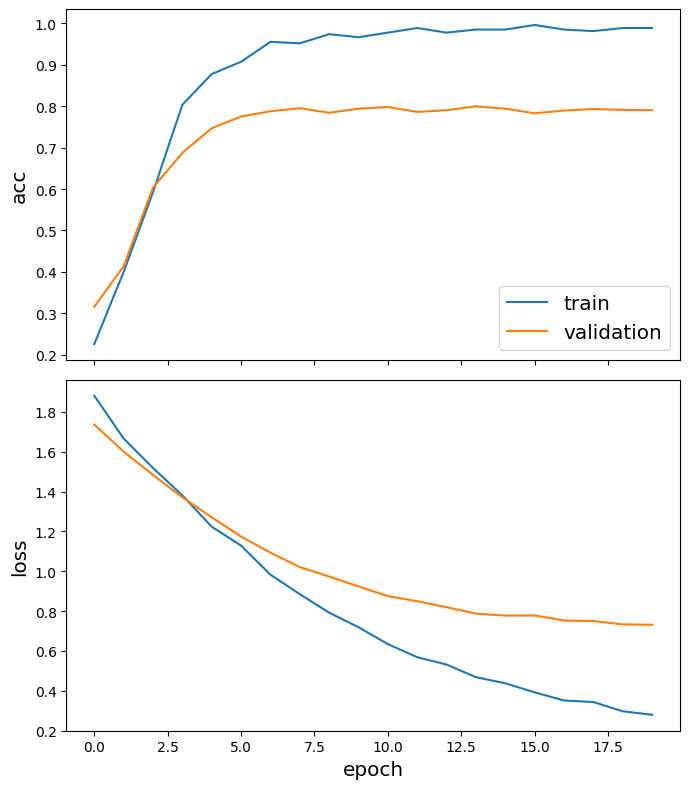

In [23]:
sg.utils.plot_history(history)

In [24]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 1s 14ms/step - loss: 0.7251 - acc: 0.7933

Test Set Metrics:
	loss: 0.7251
	acc: 0.7933


###### Vignette issue
I had trouble with the parts here, my flow needed 2 inputs including the targets.  The generator.flow() call was problematic and needed the targets to go with the input nodes.  The error message looked like:

   ValueError: Layer "model_2" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None) dtype=float32>]

In [25]:
index_list = [c for c in test_subjects.index] + [c for c in train_subjects.index]

In [26]:
all_targ = np.concatenate((test_targets, train_targets),axis=0)

In [27]:
all_gen = generator.flow(index_list, all_targ)

In [28]:
all_predictions = model.predict(all_gen)

 6/55 [==>...........................] - ETA: 0s

2023-11-17 14:05:50.746659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 12ms/step


In [29]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [30]:
np.concatenate((test_subjects.values, train_subjects.values))

array(['Genetic_Algorithms', 'Probabilistic_Methods',
       'Genetic_Algorithms', ..., 'Genetic_Algorithms', 'Rule_Learning',
       'Reinforcement_Learning'], dtype=object)

In [31]:
df = pd.DataFrame({"Predicted": node_predictions, 
                   "True": np.concatenate((test_subjects.values, train_subjects.values))})
df.index = index_list   # Having the right index is helpful for later steps
df.head(10)

,Predicted,True
650814,Genetic_Algorithms,Genetic_Algorithms
31483,Probabilistic_Methods,Probabilistic_Methods
601462,Genetic_Algorithms,Genetic_Algorithms
1114388,Neural_Networks,Theory
58540,Reinforcement_Learning,Reinforcement_Learning
1110531,Rule_Learning,Case_Based
1131728,Case_Based,Case_Based
481073,Reinforcement_Learning,Reinforcement_Learning
1105932,Rule_Learning,Rule_Learning
1153056,Reinforcement_Learning,Reinforcement_Learning


In [32]:
df['True'].value_counts(normalize=True)

True
Neural_Networks           0.302068
Probabilistic_Methods     0.157312
Genetic_Algorithms        0.154357
Theory                    0.129616
Case_Based                0.110044
Reinforcement_Learning    0.080133
Rule_Learning             0.066470
Name: proportion, dtype: float64

In [33]:
df['Predicted'].value_counts(normalize=True)

Predicted
Neural_Networks           0.303545
Genetic_Algorithms        0.182053
Probabilistic_Methods     0.159897
Theory                    0.119276
Case_Based                0.103397
Reinforcement_Learning    0.073486
Rule_Learning             0.058346
Name: proportion, dtype: float64

#### Create a NetworkX graph to save it as GraphML, e.g. for visualisation in Gephi. This adds the predictions to the graph before saving too.

In [34]:
#Gnx = G.to_networkx(feature_attr='feat')  # Can put in features this way
Gnx = G.to_networkx(feature_attr=None)

In [35]:
type(Gnx)

networkx.classes.multigraph.MultiGraph

In [36]:
list(Gnx.nodes(data=True))[0:5]

[(31336, {'label': 'paper'}),
 (1061127, {'label': 'paper'}),
 (1106406, {'label': 'paper'}),
 (13195, {'label': 'paper'}),
 (37879, {'label': 'paper'})]

In [37]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

###### Also add isTrain and isCorrect node attributes:

In [38]:
for nid in train_subjects.index:
    Gnx.nodes[nid]["isTrain"] = True

for nid in test_subjects.index:
    Gnx.nodes[nid]["isTrain"] = False

In [39]:
for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = (
        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    )

###### Save in GraphML format

In [40]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

## Node embeddings

In [41]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

As above, the code below needed to be modified.  Their "all_mapper" is my "all_gen"

In [42]:
emb = embedding_model.predict(all_gen)
emb.shape

12/55 [=====>........................] - ETA: 0s

2023-11-17 14:05:51.986405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 12ms/step


(2708, 32)

###### Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

Minor modifications are again needed due to workarounds above

In [43]:
X = emb
#y = np.argmax(target_encoding.transform(node_subjects), axis=1)
y = np.argmax(target_encoding.transform(np.concatenate((test_subjects.values, 
                                                        train_subjects.values))), 
              axis=1)

In [44]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=df.index) # workaround
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

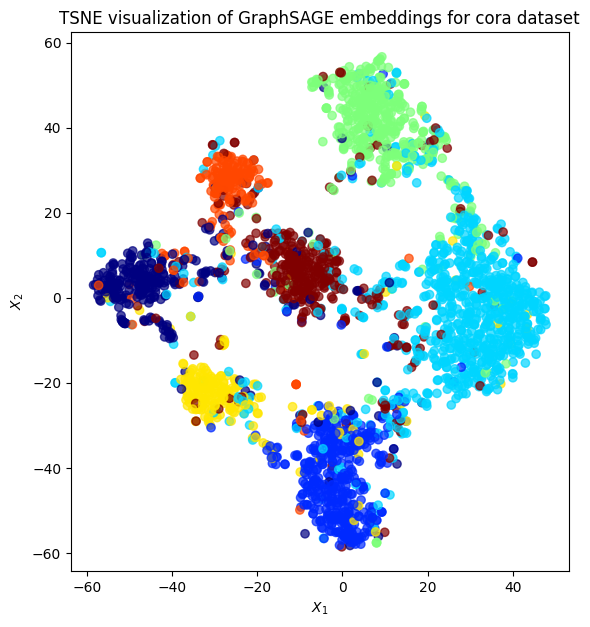

In [45]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

Yay it worked!  Now I want to change this to a binary classifier to get an idea how that goes